In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Segmentation Models: using `keras` framework.


In [2]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [3]:
seed = 24
batch_size = 16
n_classes = 8

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

In [5]:
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        target_size = (64, 64),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        target_size = (64, 64),
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [8]:
val_img_path = "/home/shrayank_mistry/Modules/data/kaggle_data/test_images/"
val_mask_path = "/home/shrayank_mistry/Modules/data/kaggle_data/test_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=8)

In [9]:
x, y = val_img_gen.__next__()

Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.


In [10]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=8

In [11]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [12]:
from keras.models import load_model

model = load_model("models/model.hdf5", compile=False)

In [13]:
total_images = 16677
itrs = total_images // batch_size

In [14]:
itrs

1042

In [15]:
ious = []
for i in range(itrs):
    test_image_batch, test_mask_batch = val_img_gen.__next__()

    #Convert categorical to integer for visualization and IoU calculation
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

    n_classes = 8
    IOU_keras = MeanIoU(num_classes=n_classes)  
    IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
    # print("Mean IoU =", IOU_keras.result().numpy())

    img_num = random.randint(0, test_image_batch.shape[0]-1)

    # plt.figure(figsize=(12, 8))
    # plt.subplot(231)
    # plt.title('Testing Image')
    # plt.imshow(test_image_batch[img_num])
    # plt.subplot(232)
    # plt.title('Testing Label')
    # plt.imshow(test_mask_batch_argmax[img_num])
    # plt.subplot(233)
    # plt.title('Prediction on test image')
    # plt.imshow(test_pred_batch_argmax[img_num])
    # plt.show()

    ious.append(IOU_keras.result().numpy())

In [16]:
# test_image_batch, test_mask_batch = val_img_gen.__next__()

# #Convert categorical to integer for visualization and IoU calculation
# test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
# test_pred_batch = model.predict(test_image_batch)
# test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

# n_classes = 5
# IOU_keras = MeanIoU(num_classes=n_classes)  
# IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
# print("Mean IoU =", IOU_keras.result().numpy())

# ious.append(IOU_keras.result().numpy())

In [17]:
# print(ious)

In [18]:
# print(ious)

[0.46995673, 0.56864095, 0.51830727, 0.5076851, 0.48420215, 0.39583522, 0.54705054, 0.48783022, 0.53151596, 0.42840466, 0.4767859, 0.57193416, 0.5222755, 0.5832903, 0.53788966, 0.5017776, 0.5530923, 0.5709558, 0.56009024, 0.5569379, 0.5152951, 0.50985867, 0.50667953, 0.53561485, 0.54703623, 0.49026674, 0.54868287, 0.544553, 0.59517395, 0.47481516, 0.44940615, 0.42732576, 0.6076852, 0.45011643, 0.4215215, 0.4529446, 0.5449673, 0.60877097, 0.51258606, 0.50763077, 0.5108677, 0.50826836, 0.5908521, 0.5156244, 0.5561908, 0.5429989, 0.51255876, 0.5180227, 0.54461557, 0.5533243, 0.5344119, 0.5419125, 0.50147855, 0.511442, 0.53748006, 0.5481125, 0.46280512, 0.5415422, 0.5680723, 0.44399437, 0.58758175, 0.50224656, 0.55136573, 0.43402115, 0.5283751, 0.5244929, 0.51142347, 0.5105568, 0.48523372, 0.5553816, 0.51138556, 0.47243315, 0.47976598, 0.5319, 0.4678165, 0.6100803, 0.5122105, 0.57316417, 0.4738894, 0.4713783, 0.5223447, 0.6024992, 0.53816736, 0.5730854, 0.5702676, 0.61185586, 0.5843276, 0.

In [19]:
print(f'Max IoU = {np.max(ious)}, Average IoU = {np.mean(ious)}')

Max IoU = 0.6605585217475891, Average IoU = 0.5226694941520691


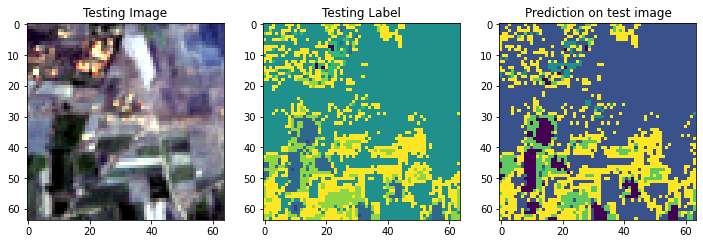

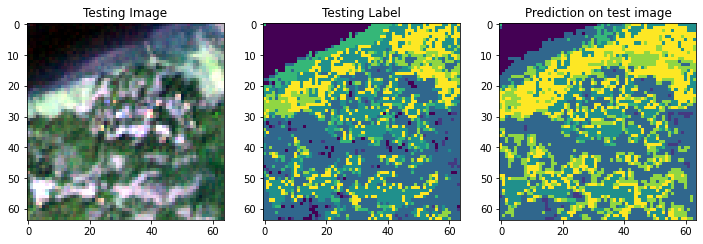

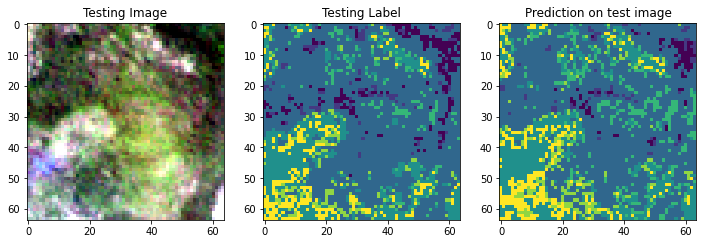

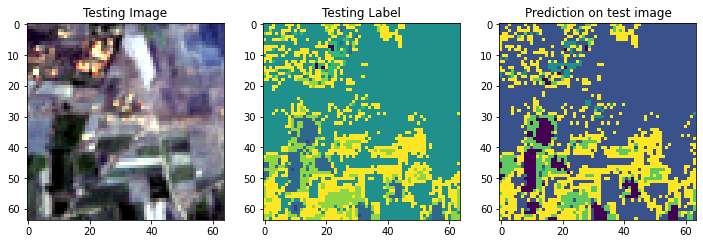

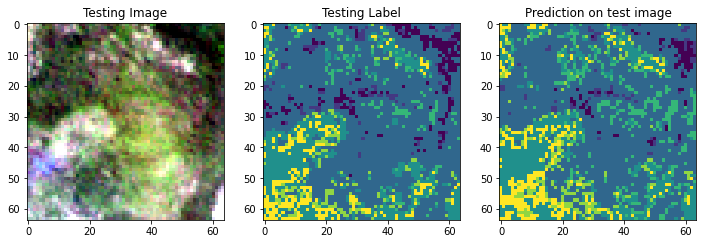

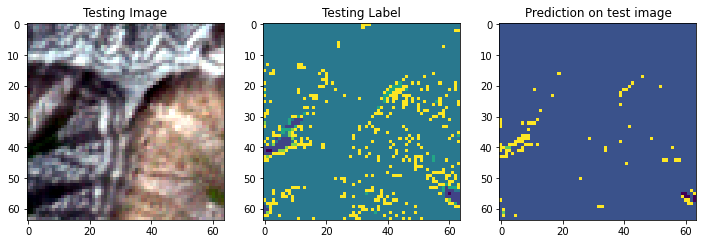

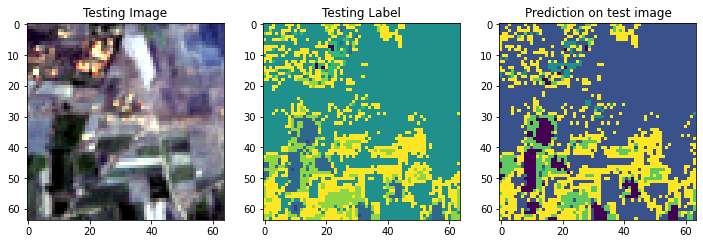

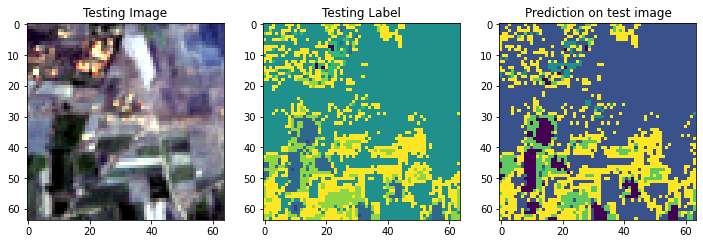

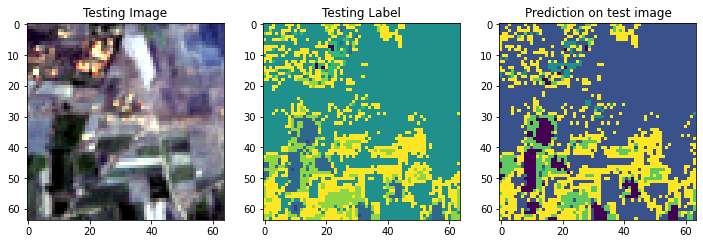

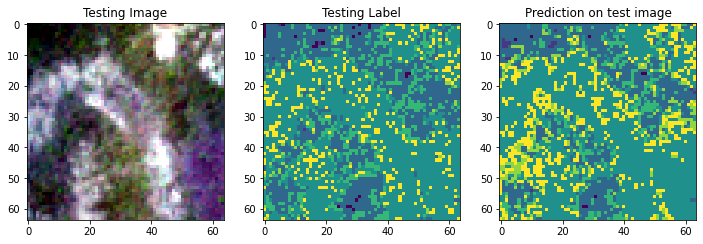

In [20]:
for i in range(10):
    img_num = random.randint(0, test_image_batch.shape[0]-1)

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_image_batch[img_num])
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_mask_batch_argmax[img_num])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_pred_batch_argmax[img_num])
    plt.show()

In [21]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

In [22]:
pixel_acc = []
for i in range(itrs):

    test_image_batch, test_mask_batch = val_img_gen.__next__()

    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

    for j in range(batch_size):
        correct = test_pred_batch_argmax[j] == test_mask_batch_argmax[j]
        pixel_acc.append(float(correct.sum() / (correct.shape[0] * correct.shape[1])))

In [23]:
len(pixel_acc)

16672

In [24]:
print(f'Max Pixel Accuracy = {np.max(pixel_acc)}, Mean Pixel Accuracy = {np.mean(pixel_acc)}')

Max Pixel Accuracy = 1.0, Mean Pixel Accuracy = 0.7579515424204879


In [25]:
metrics = {'Recall': [],
           'Precision': [],
           'F1-Score': [],
           'Kappa': []}

In [26]:
itrs

1042

In [28]:
c = 8
for x in range(itrs):
    test_image_batch, test_mask_batch = val_img_gen.__next__()

    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

    for y in range(batch_size):
        target = test_mask_batch_argmax[y]
        prediction = test_pred_batch_argmax[y]

        matrix = np.zeros((c, c))
        rows = target.shape[0]
        cols = target.shape[1]

        for i in range(rows):
            for j in range(cols):
                target_pixel = target[i][j]
                predict_pixel = prediction[i][j]
        
                matrix[predict_pixel][target_pixel] = matrix[predict_pixel][target_pixel] + 1
        
        true_positives = 0
        false_negatives = 0
        false_positives = 0

        for i in range(c):
            true_positives = true_positives + matrix[i][i]
            for j in range(c):
                if (i == j):
                    continue
                false_negatives += matrix[i][j]
        
        recall = true_positives/(true_positives + false_negatives)
        metrics['Recall'].append(recall)

        for i in range(c):
            true_positives = true_positives + matrix[i][i]
            for j in range(c):
                if (i == j):
                    continue
                false_positives += matrix[j][i]
        
        precision = true_positives/(true_positives + false_negatives) 
        metrics['Precision'].append(precision)

        fmeasure = 2 * precision * recall / (precision + recall)
        metrics['F1-Score'].append(fmeasure)

        diagonal_sum = 0
        row_col_sum = 0
        for i in range(c):
            diagonal_sum = diagonal_sum + matrix[i][i]
            row_sum, col_sum = 0, 0
            for j in range(c):
                row_sum += matrix[i][j]
                col_sum += matrix[j][i]
            row_col_sum = row_col_sum + (row_sum * col_sum)
        
        N = rows * cols
        kappa = ((N * diagonal_sum) - row_col_sum) / ((N * N) - row_col_sum)


        metrics['Kappa'].append(kappa)

In [29]:
kappa = []
for m in metrics['Kappa']:
    if np.isnan(m):
        kappa.append(0)
    else:
        kappa.append(m)

In [30]:
len(metrics['Recall'])

16677

In [31]:
print(len(metrics['Recall']), len(metrics['Precision']), len(metrics['F1-Score']), len(kappa))

16677 16677 16677 16677


In [32]:
np.mean(metrics['Recall']), np.mean(metrics['Precision']), np.mean(metrics['F1-Score']), np.mean(kappa)

(0.7580541519336137, 0.8558119789976875, 0.803011466118916, 0.5721392944925172)

In [33]:
import pandas as pd

In [34]:
mts = np.array([np.mean(metrics['Recall']), np.mean(metrics['Precision']), np.mean(metrics['F1-Score']), np.mean(kappa)])

In [35]:
metrics_df = pd.DataFrame(mts.reshape(-1, 4), columns = ['Recall', 'Precision', 'F1-Score', 'Kappa'])

In [36]:
import seaborn as sns

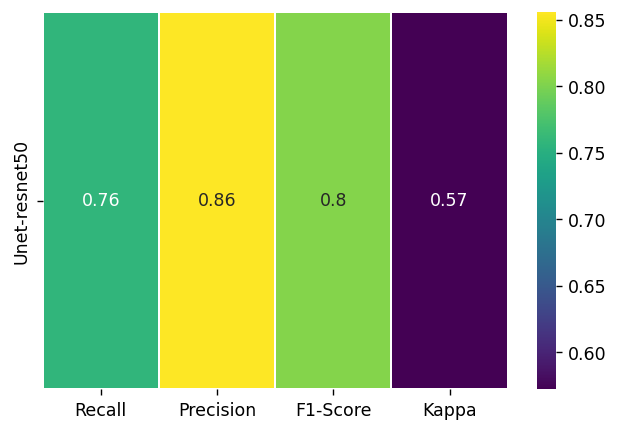

In [37]:
plt.figure(figsize = (6, 4), dpi = 125)
sns.heatmap(metrics_df[['Recall', 'Precision', 'F1-Score', 'Kappa']], annot = True, linewidths = 0.5, 
            cmap = 'viridis', yticklabels = ['Unet-resnet50']);

In [38]:
print(f'Max IoU = {np.max(ious)}, Average IoU = {np.mean(ious)}')
print(f'Max Pixel Accuracy = {np.max(pixel_acc)}, Mean Pixel Accuracy = {np.mean(pixel_acc)}')

Max IoU = 0.6605585217475891, Average IoU = 0.5226694941520691
Max Pixel Accuracy = 1.0, Mean Pixel Accuracy = 0.7579515424204879


### Confusion Matrix Average

In [40]:
c = 8
matrix = np.zeros((c, c))
for x in range(itrs):
    test_image_batch, test_mask_batch = val_img_gen.__next__()

    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

    for y in range(batch_size):
        target = test_mask_batch_argmax[y]
        prediction = test_pred_batch_argmax[y]

        # matrix = np.zeros((c, c))
        rows = target.shape[0]
        cols = target.shape[1]

        for i in range(rows):
            for j in range(cols):
                target_pixel = target[i][j]
                predict_pixel = prediction[i][j]
        
                matrix[predict_pixel][target_pixel] = matrix[predict_pixel][target_pixel] + 1
    

In [41]:
matrix = np.array(matrix) / len(metrics['Recall'])

In [1]:
classes = ['Unclassified', 'Water', 'DenseForest', 'SparseForest', 'BarrenLand', 'Urban', 'FarmLand', 'FallowLand']

In [2]:
matrix = pd.DataFrame(matrix)
plt.figure(figsize = (8, 8), dpi = 200)
sns.heatmap(matrix, annot = True, linewidths=.5);
# plt.ylabel('Classes');

plt.yticklabels(classes)
# plt.xlabel(f'{model_names[index]}')
# plt.savefig(f'{model_names[index]}_confusion_matrix_table.jpg', bbox_inches = 'tight')
# index = index + 1

NameError: name 'pd' is not defined

In [51]:
classes = ['Unclassified', 'Water', 'DenseForest', 'SparseForest', 'BarrenLand', 'Urban', 'FarmLand', 'FallowLand']

prod_cons = []
c = 8
for x in range(itrs):
    test_image_batch, test_mask_batch = val_img_gen.__next__()

    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

    for y in range(batch_size):
        target = test_mask_batch_argmax[y]
        prediction = test_pred_batch_argmax[y]

        matrix = np.zeros((c, c))
        rows = target.shape[0]
        cols = target.shape[1]

        for i in range(rows):
            for j in range(cols):
                target_pixel = target[i][j]
                predict_pixel = prediction[i][j]
        
                matrix[predict_pixel][target_pixel] = matrix[predict_pixel][target_pixel] + 1
        
        class_positive = 0
        class_metrics = []

        for i in range(c):
            class_positive = matrix[i][i]
            class_classified = 0
            class_reference = 0

            for j in range(c):
                class_classified += matrix[i][j]
            
            for j in range(c):
                class_reference += matrix[j][i]
            
            user_acc = 0 if (class_positive == 0 or class_classified == 0) else (class_positive/class_classified)
            prod_acc = 0 if (class_positive == 0 or class_reference == 0) else (class_positive/class_reference)
            class_metrics.append([classes[i], user_acc, prod_acc])
        
        prod_cons.append(class_metrics)
            

In [67]:
t = prod_cons[0]
for i in range(len(prod_cons) - 1):
    y = prod_cons[i]
    for j in range(len(t)):
        t[j][1] += y[j][1]
        t[j][2] += y[j][2]

In [69]:
for j in range(len(t)):
    t[j][1] = t[j][1] / len(metrics['Recall'])
    t[j][2] = t[j][2] / len(metrics['Recall'])

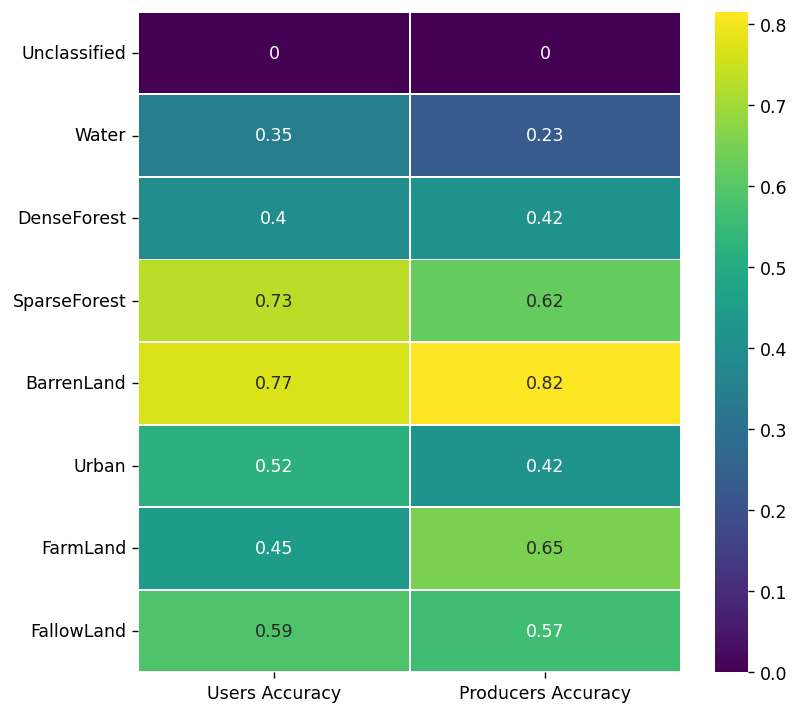

In [72]:
class_metrics = pd.DataFrame(t, columns = ["Class", "Users Accuracy", "Producers Accuracy"])
class_metrics.set_index('Class')

plt.figure(figsize = (7, 7), dpi = 125)
sns.heatmap(class_metrics[['Users Accuracy', 'Producers Accuracy']], annot = True, linewidths = 0.5, 
        cmap = 'viridis', yticklabels = classes);